In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install import-ipynb
import import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=778383a0678719d97f7e8c8fb9ced11c11a30c62e30097cccdcac94a8469e5b1
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
%cd "drive/MyDrive/Bionformatics_Project/Colab"

/content/drive/.shortcut-targets-by-id/1he9S1Es-XalZ9vgCRMbTTNd6cXeRkkFI/Bionformatics_Project/Colab


importing Jupyter notebook from /content/drive/.shortcut-targets-by-id/1he9S1Es-XalZ9vgCRMbTTNd6cXeRkkFI/Bionformatics_Project/Colab/Classes/DataManager.ipynb
importing Jupyter notebook from /content/drive/.shortcut-targets-by-id/1he9S1Es-XalZ9vgCRMbTTNd6cXeRkkFI/Bionformatics_Project/Colab/Classes/Transformer.ipynb
Populating the interactive namespace from numpy and matplotlib
KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 10500, 32], name='tf.compat.v1.shape/Shape:0', description="created by layer 'tf.compat.v1.shape'")
KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[1, None, 32], name='tf.compat.v1.shape_1/Shape:0', description="created by layer 'tf.compat.v1.shape_1'")
KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[1, None, 32], name='tf.compat.v1.shape_2/Shape:0', description="created by layer 'tf.compat.v1.shape_2'")
model built
Model: "model"
_______

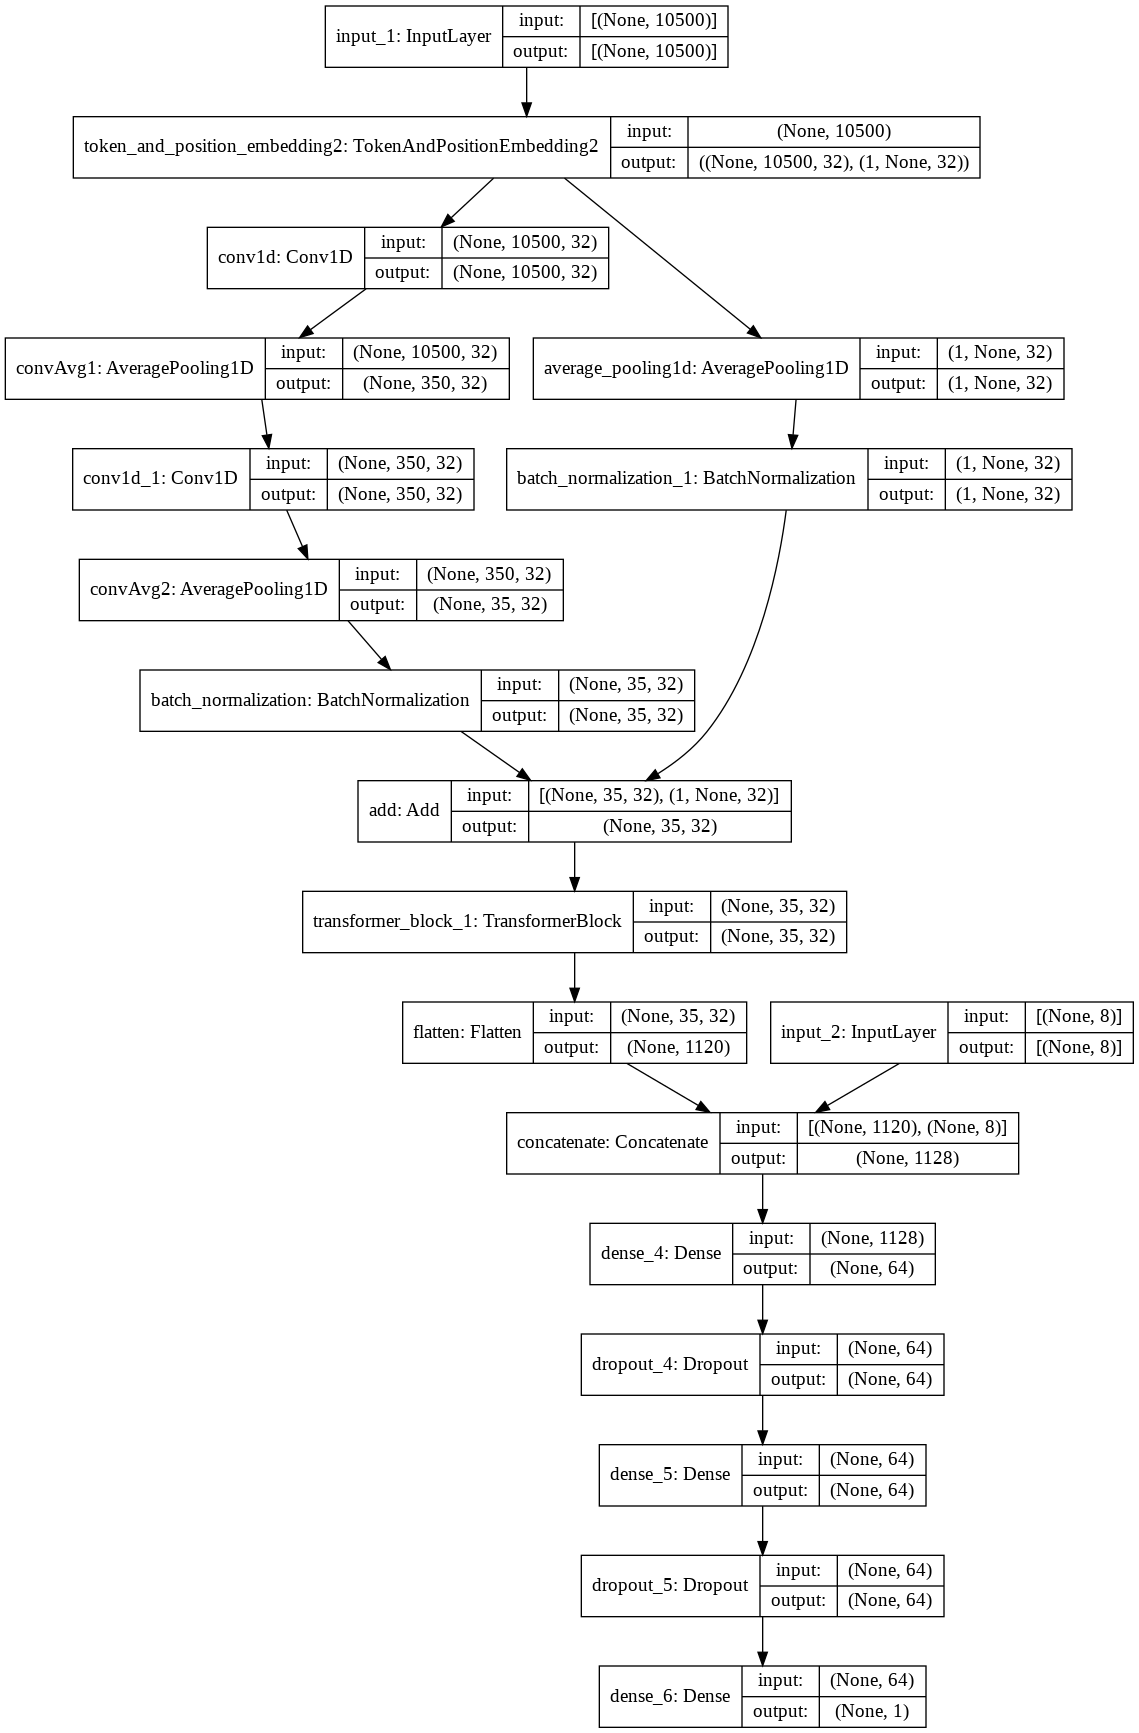


Parameters:
{'checkpoint_dir': 'posSkip/', 'model_type': 'posSkip', 'n_epochs': 300, 'batch_size': 256, 'learning_rate': 0.001, 'momentum': 0.9, 'maxlen': 10500, 'embed_dim': 32, 'num_heads': 4, 'ff_dim': 64, 'vocab_size': 4, 'dense': 64, 'dropout_rate': 0.1, 'lr_reduction_epoch': 60, 't_rate': 0.1, 'patience': 20, 'optimizer': 'SGD', 'pe': 10500, 'n_layers': 3, 'shuffle': True, 'logdir': 'logs/posSkip/', 'loss': 'mae', 'history': '', 'model': <tensorflow.python.keras.engine.functional.Functional object at 0x7f0a77625b50>}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
from Classes.DataManager import DataManager
from Classes.Transformer import projTransformer
from tensorflow import keras
import tensorflow as tf
import numpy as np

%load_ext tensorboard

data loading takes at most 30s, we can improve it saving the numerical representation of sequences

In [ ]:
print("> Loading DataManager...")
dm = DataManager(transformer=True, remove_indicted=True)

print("> Loading train data...")
X_trainhalflife, X_trainpromoter, y_train, geneName_train = dm.get_train(True, True)

print("> Loading validation data...")
X_validationhalflife, X_validationpromoter, y_validation, geneName_validation, _ = dm.get_validation(True, True)

print("> Loading test data...")
X_testhalflife, X_testpromoter, y_test, geneName_test = dm.get_test(True, True)

print("\n**************\n     DONE\n**************\n")

> Loading DataManager...
> Loading train data...
> Loading validation data...
> Loading test data...

**************
     DONE
**************



Preprocessing-> Padding

In [ ]:
leftpos  = 3_000          #3_000 
rightpos = 13_500         #13_500
maxlen   = rightpos-leftpos
print("maxlen: ",maxlen)

maxlen:  10500


In [ ]:
X_trainpromoter_p      = X_trainpromoter[:, leftpos:rightpos]
X_validationpromoter_p = X_validationpromoter[:, leftpos:rightpos]
X_testpromoter_p       = X_testpromoter[:, leftpos:rightpos]

#Transformer Original


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from scipy import stats
from matplotlib import pyplot
import numpy as np
import datetime, os
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, Image
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
import math
import h5py
import pickle

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 4), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_zero_mask(shape=(256, 1, 1, 35)):
    return tf.zeros( shape, dtype=tf.dtypes.float32, name=None )

In [ ]:
class create_mask(tf.keras.layers.Layer):
  def __init__(self):
    super(create_mask, self).__init__()

  def call(self, x):  # training

    mask = create_zero_mask( (tf.shape(x)[0], 1, 1, tf.shape(x)[-1]) )
    # print("mask: ", mask.shape, "x: ", x.shape)
    return x, mask

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):  # training

    attn_output, att_weights = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output)    # training
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output)  # training
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2, att_weights

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, mask, training):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
checkpoint_dir="TPU"
model_type="original"
n_epochs=10 
batch_size=30 
learning_rate=5e-4
momentum=0.9
# maxlen=10500
embed_dim=128
num_heads=2
ff_dim=embed_dim*4
vocab_size=5
dense=64
lr_reduction_epoch=60
dropout_rate=0.005
t_rate = 0.1
patience=20
opt="Adam"
pe = 10_500
n_layers = 1
logdir=None

def createmodel():
    #inputs
    input1 = layers.Input(shape=(maxlen))
    input2 = layers.Input(shape=(8))

    #embedding

    x, enc_mask = create_mask()(input1)
    x, att_weights = Encoder(n_layers, embed_dim, num_heads, ff_dim, vocab_size, pe, t_rate)(x, enc_mask)

    #FC
    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)  # channels_last # channels_first
    # x = layers.Flatten()(x)

    x = layers.Concatenate()([x, input2])
    #dense1
    x = layers.Dense(dense, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    #dense2
    x = layers.Dense(dense, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    #output
    output = layers.Dense(1, activation="linear")(x)

    print("model built")
    model = keras.Model(
        inputs=[input1, input2],
        outputs=[output],
        )
    model.summary()
    img = keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)
    display(img)
    return model





INFO:tensorflow:Initializing the TPU system: grpc://10.24.198.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.24.198.218:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


model built
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10500)]      0                                            
__________________________________________________________________________________________________
create_mask (create_mask)       ((None, 10500), (Non 0           input_1[0][0]                    
__________________________________________________________________________________________________
encoder (Encoder)               ((None, 10500, 128), 198912      create_mask[0][0]                
                                                                 create_mask[0][1]                
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 128)          0           encoder[0][0]    

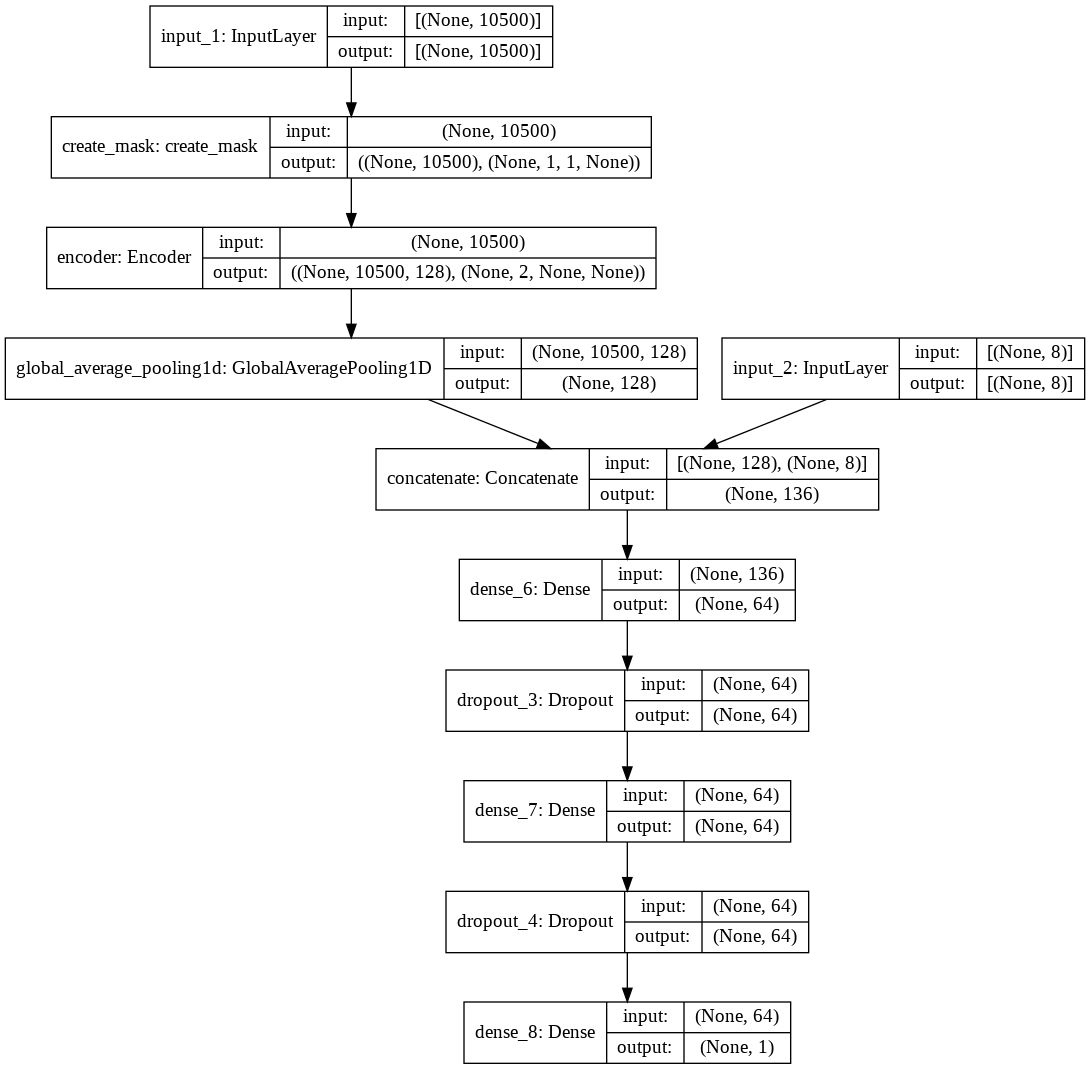

Epoch 1/250
545/545 [==============================] - 105s 175ms/step - loss: 0.8618 - val_loss: 0.7969
Epoch 2/250
545/545 [==============================] - 88s 161ms/step - loss: 0.7128 - val_loss: 0.6332
Epoch 3/250
545/545 [==============================] - 88s 161ms/step - loss: 0.6684 - val_loss: 0.6722
Epoch 4/250
545/545 [==============================] - 88s 161ms/step - loss: 0.6387 - val_loss: 0.6004
Epoch 5/250
545/545 [==============================] - 88s 161ms/step - loss: 0.6474 - val_loss: 0.6303
Epoch 6/250
545/545 [==============================] - 88s 162ms/step - loss: 0.6216 - val_loss: 0.5770
Epoch 7/250
545/545 [==============================] - 88s 161ms/step - loss: 0.6130 - val_loss: 0.5896
Epoch 8/250
545/545 [==============================] - 88s 161ms/step - loss: 0.6191 - val_loss: 0.5922
Epoch 9/250
545/545 [==============================] - 88s 161ms/step - loss: 0.6117 - val_loss: 0.5825
Epoch 10/250
545/545 [==============================] - 88s 161

In [ ]:
# # Clear any logs from previous runs
!rm -rf ./logs/transformer_classic_0-002/

model_type="classic"
logdir = f"transformer_{model_type}_0-002"
# net = projTransformer(checkpoint_dir="tuning/", model_type=model_type, n_epochs=300, batch_size=256, learning_rate=1e-3, 
#                       lr_reduction_epoch=30, maxlen=maxlen, embed_dim=32, num_heads=1, ff_dim=64, dense=64, dropout_rate=0.1, logdir=logdir)

######################################################################################################################
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)


with strategy.scope():
    history = tf.keras.callbacks.History()
    check_cb = ModelCheckpoint(os.path.join(f"checkpoint/{checkpoint_dir}", f'bestmodel_transformer_{model_type}'), monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    earlystop_cb = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min', restore_best_weights=True)
    #optimizer
    learning_rate = CustomSchedule(embed_dim)

    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
    net = createmodel()
    net.compile(optimizer=optimizer, loss='mse')
########################################################################################################################

history = net.fit(
    x = [X_trainpromoter_p, X_trainhalflife],
    y = y_train,
    validation_data = ([X_validationpromoter_p, X_validationhalflife], y_validation),
    steps_per_epoch=X_trainpromoter_p.shape[0]//batch_size,
    epochs=250,
    shuffle=True, 
    callbacks=[earlystop_cb]
)



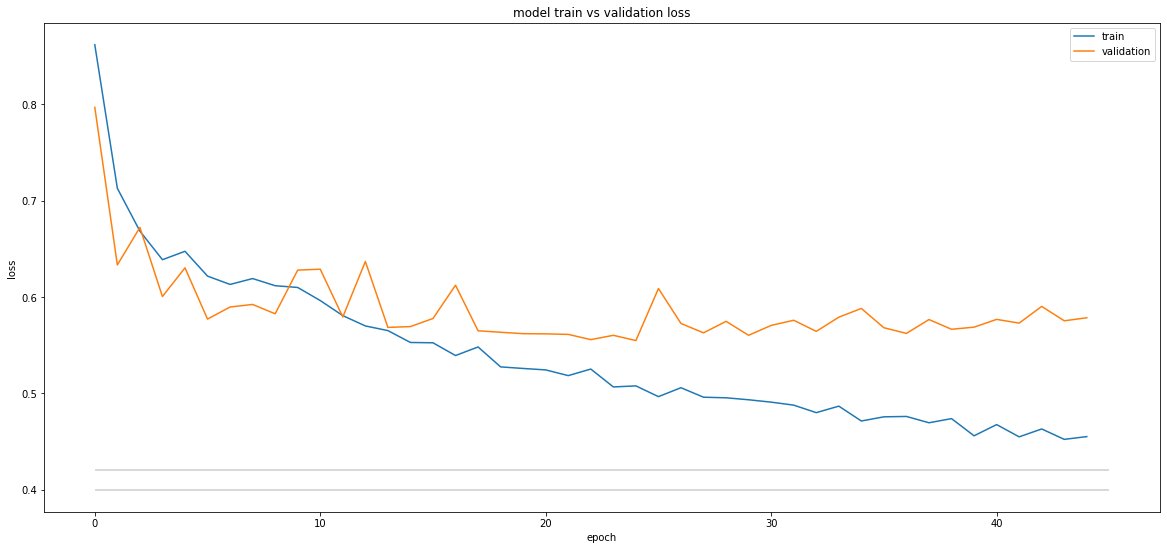

In [ ]:
plt.rcParams["figure.figsize"] = (20,9)
plt.hlines(0.4, 0, len(history.history['loss']) , alpha = 0.2)
plt.hlines(0.42, 0, len(history.history['loss']) , alpha = 0.2 )
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [ ]:
predictions = net.predict([X_testpromoter_p, X_testhalflife]).flatten()
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(predictions, y_test)

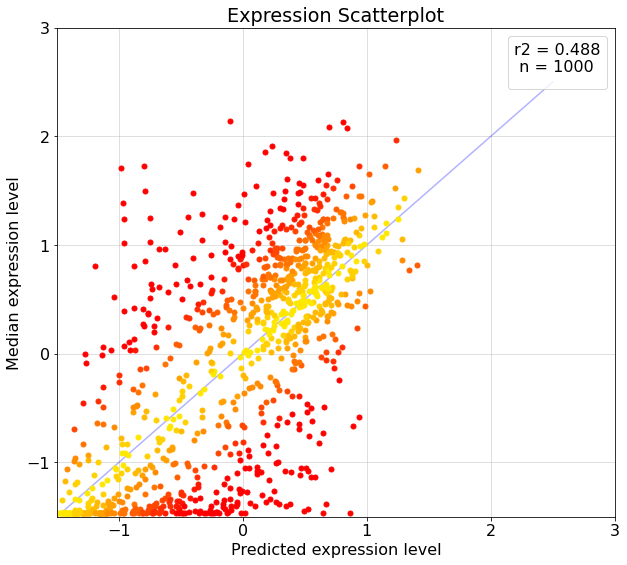

In [ ]:
from matplotlib import cm
viridis = cm.get_cmap('autumn', 12)
diff = y_test - predictions
diff = np.abs(diff)

### plt size
plt.rcParams["figure.figsize"] = (10,9)
### plt fontsize
plt.rcParams.update({'font.size': 16})

### set title
plt.title("Expression Scatterplot")
### plot
bis = np.arange(-1.5, 3, 2)
plt.plot(bis, bis,  f"b", alpha=0.3)
for p, yi, c in zip(predictions, y_test, diff):
    plt.plot(p, yi,  f".", markersize=10, color=viridis((1.0-c)/1.1))

### set ticks
plt.xticks([i for i in range(-1, 4)])
plt.yticks([i for i in range(-1, 4)])
### set labels
plt.xlabel("Predicted expression level")
plt.ylabel("Median expression level")
### create legend
plt.legend(loc="upper right", title=f"r2 = %.3f\n n = 1000" % r_value**2)
### set ylim
plt.ylim((-1.5,3))
plt.xlim((-1.5,3))
### grid
plt.grid(alpha=0.5)
### save
# if self.save:
#     plt.savefig(f"{self.dir}{self.filename}.png")
### show
plt.show()

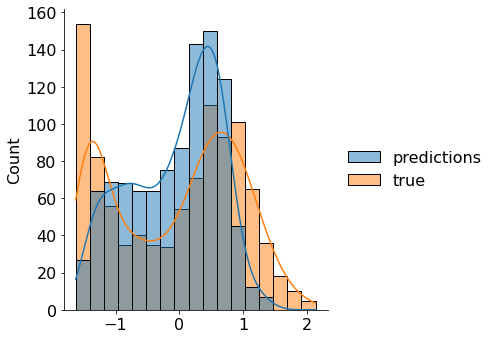

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({"predictions":predictions, "true":y_test})
ax = sns.displot(data=df, kde=True)
#  '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
# styles = ["dashdot", "solid"]
# for line, s in zip(ax.get_lines(), styles):
#     line.set_alpha(0.5)
#     line.set_linestyle(s)
plt.show()